<a href="https://colab.research.google.com/github/ms03831/image_captioning_tensorflow/blob/master/image_captioning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading and unzipping data
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip 
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip 
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

In [9]:
#loading packages
import os
import numpy as np
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Input, LSTM, Add, Lambda
from matplotlib import pyplot as plt

In [3]:
#this function loads every caption in a dictionary corresponding it's and image
# and appends start_token and end_token to start and end of it.
def load_pad_sequences(directory):
    image_caption = dict()
    lines = open(directory, 'r').readlines() #this gives list of lines
    for line in lines:
        tokens = line.strip().split('\t')
        # each line is image_id#n "tab" caption where n is the caption number
        image_id, image_desc = tokens[0], tokens[1] 
        image_id = image_id[:-2]  #getting rid of caption number from image id
        if image_id not in image_caption:
            image_caption[image_id] = []
        image_caption[image_id].append('start_token ' + image_desc.strip() + ' end_token')
    return image_caption 

dir = 'Flickr8k.token.txt'
image_caption = load_pad_sequences(dir)
#five captions of the first image
image_caption[list(image_caption.keys())[:1][0]]

['start_token A child in a pink dress is climbing up a set of stairs in an entry way . end_token',
 'start_token A girl going into a wooden building . end_token',
 'start_token A little girl climbing into a wooden playhouse . end_token',
 'start_token A little girl climbing the stairs to her playhouse . end_token',
 'start_token A little girl in a pink dress going into a wooden cabin . end_token']

In [4]:
#removing single letter words from captions
photo_ids = list(image_caption.keys())
print('before : ', image_caption[photo_ids[0]][0])
for image, caption in image_caption.items():
    for i in range(len(caption)):
        image_caption[image][i] = ' '.join([word for word in image_caption[image][i].split() if len(word) > 1])
print('after : ', image_caption[photo_ids[0]][0])

#list of all captions
captions_list = []
for captions in image_caption.values():
     captions_list.extend([cap for cap in captions])

#print(captions_list[0])
#the max length of caption(number of words) in our dataset
for i in captions_list:
    if len(i.split()) > 100:
        print(i)
max_length_desc = np.argmax([len(caption) for caption in captions_list])
max_length = captions_list[max_length_desc].split()
print(len(max_length), max_length)

before :  start_token A child in a pink dress is climbing up a set of stairs in an entry way . end_token
after :  start_token child in pink dress is climbing up set of stairs in an entry way end_token
start_token child in pink dress is climbing up set of stairs in an entry way end_token
34 ['start_token', 'An', 'African-American', 'man', 'wearing', 'green', 'sweatshirt', 'and', 'blue', 'vest', 'is', 'holding', 'up', 'dollar', 'bills', 'in', 'front', 'of', 'his', 'face', 'while', 'standing', 'on', 'busy', 'sidewalk', 'in', 'front', 'of', 'group', 'of', 'men', 'playing', 'instruments', 'end_token']


In [5]:
string_caption = ' '.join(captions_list) #all captions as a string separated by just space
list_of_words =  [word for word in string_caption.split() if len(word) > 1] 
unique_words =  set(list_of_words)
print(len(unique_words))
vocabulary = dict()

#dictionary of vocabulary and their count
for word in list_of_words:
    if word in vocabulary:
        vocabulary[word] += 1
    else:
        vocabulary[word] = 1
print(len(vocabulary))

9595
9595


In [6]:
#dictionary of reducred vocabulary (words that appear < 19 times in our data)
reduced_vocabulary = dict()
for word, count in vocabulary.items():
    if count > 10 and word not in reduced_vocabulary:
        reduced_vocabulary[word] = count
print('reduced vocabulary %d ' % len(reduced_vocabulary))

reduced vocabulary 1888 


In [7]:
idx_word = {} #index to word
word_idx = {} #word to index  both useful for embedding 
idx = 0
for w in vocabulary:
    word_idx[w] = idx
    idx_word[idx] = w
    idx += 1

In [10]:
## Vgg model for feature extraction, popping the last two layers. because we want 
# 4096 as feature vector. the last layers are mainly for classification
vgg_model = VGG16(weights = 'imagenet')
feature_extractor = keras.models.Sequential([
                        *vgg_model.layers[:-2]
                    ])
for i in feature_extractor.layers:
    i.trainable = False
feature_extractor.trainable = False

In [11]:
#loads image and converts it into an array
def load_process(filenames):
    #lambda function that takes a file name and loads it into an array of defined target size
    load = lambda filename: img_to_array(load_img('Flicker8k_Dataset/'+filename, target_size=(224, 224, 3)))
    if len(filenames) > 1:
        loaded_images = np.array([load(image) for image in filenames])
    else:
        loaded_images = load(filenames)
    return loaded_images
        

In [12]:
#extracting vgg features
def vgg_features(images_files):
    batch_size = 250
    
    image_features = []
    #processing in batch for faster processing
    for batch_start in range(0, len(images_files) - batch_size + 1, batch_size):
        images_to_process = load_process(images_files[batch_start:batch_start+batch_size])
		# reshape and preprocess data for vgg
        images_to_process = images_to_process.reshape(-1, 224, 224, 3)
        images_to_process = preprocess_input(images_to_process)
		# extracting features
        features250 = feature_extractor.predict(images_to_process, verbose=0)
        image_features.append(features250)
        print(",extracting ", batch_start, end=' ')
    image_features = np.concatenate(image_features, axis = 0)
    return image_features

def image_features(train, test):
    #train and test are directories contraining image names of images
    def load_file_names(dir):
        file = open(dir)
        images_files = list(set([line.strip() for line in file.readlines()]))
        return images_files
    train_files = load_file_names(train)
    test_files = load_file_names(test)
    train_features = vgg_features(train_files)
    test_features = vgg_features(test_files)
    return (train_files, train_features), (test_files, test_features) 

#train_files contain file names and train_features contain features correspoding to images in train_files. same 
#for test
(train_files, train_features), (test_files, test_features) = image_features('Flickr_8k.trainImages.txt', 'Flickr_8k.devImages.txt')


,extracting  0 ,extracting  250 ,extracting  500 ,extracting  750 ,extracting  1000 ,extracting  1250 ,extracting  1500 ,extracting  1750 ,extracting  2000 ,extracting  2250 ,extracting  2500 ,extracting  2750 ,extracting  3000 ,extracting  3250 ,extracting  3500 ,extracting  3750 ,extracting  4000 ,extracting  4250 ,extracting  4500 ,extracting  4750 ,extracting  5000 ,extracting  5250 ,extracting  5500 ,extracting  5750 ,extracting  0 ,extracting  250 ,extracting  500 ,extracting  750 

In [13]:
print('Extracted Train Features: ', train_features.shape)
print('Extracted Test Features: ', test_features.shape)

Extracted Train Features:  (6000, 4096)
Extracted Test Features:  (1000, 4096)


In [14]:
#loading pre-trained Word2Vec model
from gensim.models import Word2Vec
from gensim import downloader as api
embedding = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [17]:
embedding_n = 300
vocabulary_size = len(vocabulary)
#get 300-dim dense vector for each of the words in our vocabulary
embedding_matrix = np.zeros((vocabulary_size, embedding_n))
for word, i in word_idx.items():
    if word in embedding:        # Words not found in the embedding index will be all zeros 
                                #because as you can see above we initliase the matrix with zeros
        vector = embedding[word]
        embedding_matrix[i] = vector
#emedding of start token
print(embedding_matrix[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
#our model!!! 

#this block encoder can be thought of as an encoder, maps the 4096 vectors 
#to a 1024 vector to get features that are more relevant for this task
################ ENCODER ################
inputs1 = Input(shape=(4096, ))
model1 = Dropout(0.3)(inputs1)
model1 = Dense(256, activation='relu')(model1)
model1 = Dropout(0.4)(model1)
model1 = Dense(512, activation='relu')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(1024, activation='relu')(model1)
################ -------- ################

################ LSTM Block ################
#this bloc is for generating words based on previous words
#and since we cant have fixed length captions so 
#we use lstm
inputs2 = Input(shape=(10, 300)) #predicting based on previous 10 words only.
model2 = LSTM(1024)(inputs2)
model2 = Dense(1024, activation='relu')(model2)
################ -------- ################

################ COMBINING BLOCK ################
#this block combines the two previous blocks, 
#image features from block 1 and 
#sequence information from block2

model3 = Add()([model1, model2])
model3 = Dropout(0.3)(model3)
model3 = Dense(1024, activation = 'relu')(model3)
model3 = Dropout(0.3)(model3)
model3 = Dense(vocabulary_size, activation = 'softmax')(model3)
################ -------- ################

'''
model1 = tf.keras.models.Sequential([
                inputs1, 
                Dropout(0.3),
                Dense(256, activation='relu'),
                Dropout(0.4),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(1024, activation='relu')
])

model2 = tf.keras.models.Sequential([
                inputs2, 
                LSTM(1024),
                Dense(1024, activation='relu')
])
print(model1.layers[-1])


model3 = tf.keras.models.Sequential([
                add_layer,
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(1024, activation='relu'),
                Dense(vocabulary_size, activation = 'softmax')
])
'''

final_model = keras.models.Model([inputs1, inputs2], model3)
final_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [19]:
#pads sequence < desired length with leading zeroes. 
def pad_sequence(sequence, c_length, d_length): 
    #c_length is current length of sequence
    #d_length is desired length of sequence
    
    return [0]*(d_length - c_length) + sequence

#embedding for every index of word in sequence.
def calculate_embedding(sequence):
    return np.array([embedding_matrix[idx] for idx in sequence])

In [32]:
# TRAIN LOOP
epochs = 10
batch_size = 256
n = 10
iteration = 0
for epoch in range(epochs):
    #batches
    for batch_start in range(0, len(train_files) - batch_size + 1, batch_size):
        print("Epoch no {0}; batch of images no: {1}".format(epoch+1, iteration +1), end = ' ')
        iteration += 1
        batch = range(batch_start, batch_start+batch_size)
        input1, input2, Y = [], [], []
        # one batch has 256 images, each image has 5 captions, and then we generate sequences
        # to train depending on each caption size (number of words.)
        for im in batch:
            image_id = train_files[im]
            image_feature_vector = train_features[im]
            for caption in image_caption[image_id]: #caption for each image
                
                for i in range(1, len(caption.split())):
                    input1.append(image_feature_vector)
                    y = word_idx[caption.split()[i]]
                    if i >= n:
                        start = max(0, n - i)
                        i2 = [word_idx[word] for word in caption.split()[start:i]]
                    else:
                        i2 = [word_idx[word] for word in caption.split()[:i]]
                        i2 = pad_sequence(i2, i, n) 
                    i2 = calculate_embedding(i2)
                    Y.append(y)
                    input2.append(i2)
        #the above batches are huge because of 256 images, each 5 caption, and each caption has many many words.
        #this function takes only 256 at a time.
        for i in range(0, len(input1)-batch_size+1, batch_size):
            lst = np.array([input2[l][:10] for l in range(i,i+batch_size)])
            #print(lst.shape)
            inp1, inp2, Y_ = input1[i:i+batch_size], lst, Y[i:i+batch_size]
            inp1 = np.array(inp1).reshape(-1, 4096)
            inp2 = np.array(inp2).reshape(-1, n, 300)
            Y_ = np.array(Y_)
            #print(inp1.shape, inp2.shape, Y_.shape)
            loss = final_model.train_on_batch([inp1, inp2], Y_)
        print(" loss: ", loss)

Epoch no 1; batch of images no: 1  loss:  3.6113257
Epoch no 1; batch of images no: 2  loss:  3.8692956
Epoch no 1; batch of images no: 3  loss:  3.501791
Epoch no 1; batch of images no: 4  loss:  3.5972977
Epoch no 1; batch of images no: 5  loss:  3.3524942
Epoch no 1; batch of images no: 6  loss:  4.0797706
Epoch no 1; batch of images no: 7  loss:  3.5035014
Epoch no 1; batch of images no: 8  loss:  4.0649962
Epoch no 1; batch of images no: 9  loss:  3.8227563
Epoch no 1; batch of images no: 10  loss:  3.661318
Epoch no 1; batch of images no: 11  loss:  3.2255056
Epoch no 1; batch of images no: 12  loss:  3.208316
Epoch no 1; batch of images no: 13  loss:  3.9597096
Epoch no 1; batch of images no: 14  loss:  3.513249
Epoch no 1; batch of images no: 15  loss:  3.7183678
Epoch no 1; batch of images no: 16  loss:  3.4963918
Epoch no 1; batch of images no: 17  loss:  3.7312703
Epoch no 1; batch of images no: 18  loss:  3.9583507
Epoch no 1; batch of images no: 19  loss:  3.2034028
Epoch 

# Random images with caption:
- The results aren't great because of limited data as well as limited training. If we train for more epochs we might get better results. 
>*** The model hasn't seen the dev images, so we can use those to generate captions and see how well it's doing**

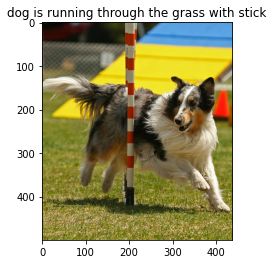

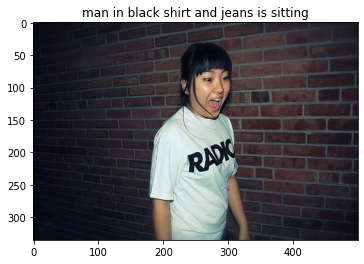

In [41]:
def vgg_predict_one(file): 
    image = img_to_array(load_img(file, target_size = (224, 224, 3)))
    image = preprocess_input(image).reshape(1,224,224,3)
    return feature_extractor.predict(image)

rand_image_idx = np.random.choice(len(test_files), 2) 
rand_image_files = [test_files[i] for i in rand_image_idx]

n = 10
dir = "Flicker8k_Dataset/"
for i in range(2):
    description = ''
    plt.imshow(img_to_array(load_img(dir+rand_image_files[i])).astype(int))
    
    #sequence_embedding = np.zeros(shape = (1, n, 300))
    image_feature_vector = vgg_predict_one(dir+rand_image_files[i])
    count = 1 #length of generated caption
    caption = 'start_token'
    while True and count <= len(max_length):
        if count >= n:
            start = max(0, n - count)
            i2 = [word_idx[word] for word in caption.split()[start:count]]
        else:
            i2 = [word_idx[word] for word in caption.split()[:count]]
            i2 = pad_sequence(i2, count, n) 
        i2 = calculate_embedding(i2).reshape(1, n, 300)
        idx = final_model.predict([image_feature_vector, i2])[0].argmax()
        if idx_word[idx] == 'end_token':
            break
        caption += ' '+ idx_word[idx]
        count += 1
    plt.title(' '.join(caption.split()[1:-1]))
    plt.show()
